In [1]:

import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import re
import unicodedata
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns
import json
# import acquire
import prepare
import wrangle as w
import model as m

from env import github_token, github_username
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_json('data2.json')

In [3]:
df.shape

(250, 3)

In [4]:
df.head()

,repo,language,readme_contents
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...
1,bitcoinbook/bitcoinbook,AsciiDoc,Code Examples: ![travis_ci](https://travis-ci....
2,bitcoinj/bitcoinj,Java,image:https://github.com/bitcoinj/bitcoinj/wor...
3,bitcoin/bips,Wikitext,"People wishing to submit BIPs, first should pr..."
4,bitcoinjs/bitcoinjs-lib,TypeScript,# BitcoinJS (bitcoinjs-lib)\n[![Github CI](htt...


In [5]:
df = w.prepare_df(df)

In [6]:
df

,repo,language,readme_contents,readme_contents_clean,length,unique
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,bitcoin core integration staging tree http bit...,3364,27
1,bitcoinj/bitcoinj,Java,image:https://github.com/bitcoinj/bitcoinj/wor...,image http github com bitcoinj bitcoinj workfl...,4642,35
2,spesmilo/electrum,Python,# Electrum - Lightweight Bitcoin client\n\n```...,electrum lightweight bitcoin client licence mi...,4270,36
3,bitcoin-wallet/bitcoin-wallet,Java,# BITCOIN WALLET\n\nWelcome to _Bitcoin Wallet...,bitcoin wallet welcome _bitcoin wallet_ standa...,1317,33
4,etotheipi/BitcoinArmory,C++,##Armory\n\n**Created by Alan Reiner on 13 Jul...,armory created alan reiner 13 july 2011 armory...,4101,38
...,...,...,...,...,...,...
122,graymauser/btcposbal2csv,Python,## Dump Bitcoin addresses with positive balanc...,dump bitcoin address positive balance simple u...,2974,37
123,square/subzero,Java,[![Build Status](https://github.com/square/sub...,build status http github com square subzero ac...,3053,31
124,gazbert/bxbot,Java,# BX-bot\n\n[![Gradle CI](https://github.com/g...,bx bot gradle ci http github com gazbert bxbot...,35813,38
125,DeFiCh/ain,C++,[![Lint](https://github.com/DeFiCh/ain/actions...,lint http github com defich action workflow li...,2882,36


In [7]:
df.language.value_counts()

Python        49
JavaScript    37
C++           21
Java          20
Name: language, dtype: int64

In [8]:
train, val, test = w.train_val_test(df, target=None, stratify=None, seed=42)
train.shape, val.shape, test.shape

((76, 6), (25, 6), (26, 6))

In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = w.x_y_split(df, 'language')

In [10]:
X_train_tfid, X_val_tfid, X_test_tfid= m.get_tfid(X_train, X_val, X_test, y_train, y_val, y_test)

In [11]:
words = w.clean_text(' '.join(train['readme_contents_clean']))

In [12]:
#### 1. What are the most common words in READMEs?

In [13]:
# w.viz_most_common_unigrams(words)

In [14]:
# w.viz_most_common_bigrams(words)

In [15]:
def viz_most_common_trigrams(words):
    '''takes in words, get top 20 bigram words, plot bar graph of top 20 bigram words'''
    
    words_trigrams = pd.Series(nltk.ngrams(words.split(), 3))
    top_20_words = words_trigrams.value_counts().head(20)
    top_20_words.sort_values().plot.barh(color='pink', width=.9, figsize=(10, 6))

    plt.title('20 Most frequently occuring words trigrams')
    plt.ylabel('Trigram')
    plt.xlabel('# Occurances')

    # make the labels pretty
    ticks, _ = plt.yticks()
    labels = top_20_words.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
    _ = plt.yticks(ticks, labels)

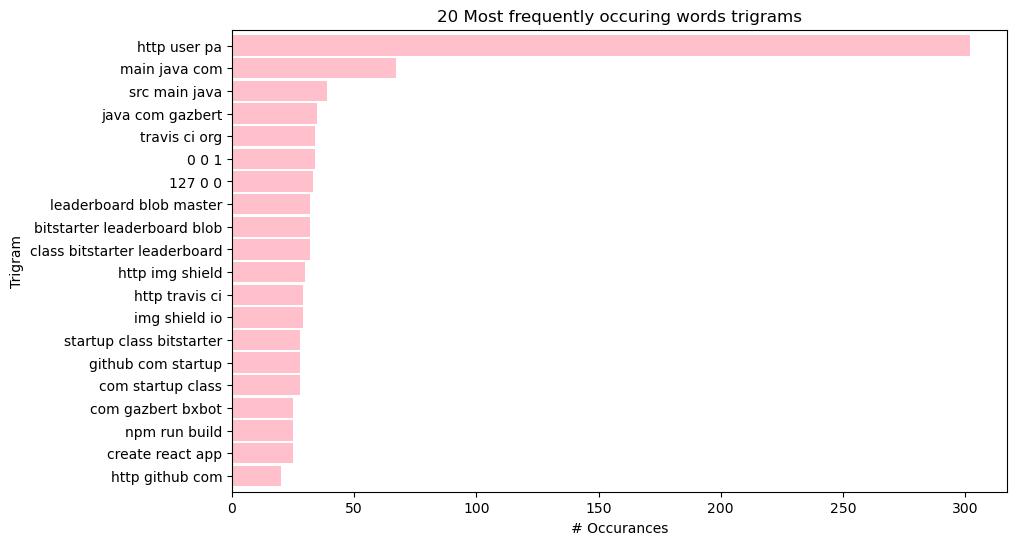

In [16]:
viz_most_common_trigrams(words)

In [17]:
#### 2. Does the length of the README vary by programming language?

In [18]:
# w.viz_length_content(train)

In [19]:
#### 3. Do different programming languages use a different number of unique words?

In [20]:
df.groupby('language').unique.value_counts()

language    unique
C++         27         5
            38         5
            36         3
            33         2
            37         2
            7          1
            20         1
            29         1
            34         1
Java        38         8
            35         3
            37         3
            31         2
            36         2
            29         1
            33         1
JavaScript  38        10
            37         7
            32         5
            22         4
            29         2
            33         2
            35         2
            9          1
            18         1
            30         1
            34         1
            36         1
Python      38        13
            35         7
            37         7
            36         5
            33         4
            27         3
            34         3
            31         2
            0          1
            20         1
            23         1
      

In [21]:
# w.viz_count_unique(train)

In [22]:
# Modeling

In [23]:
m.get_baseline_accuracy(y_train)

Baseline accuracy: 39.0 %


In [24]:
df_1 = m.decision_tree(X_train_tfid, X_val_tfid, y_train, y_val)

In [25]:
df_1.sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(10)

,max_depth,train_accuracy,validate_accuracy,difference
3,4,0.763158,0.76,0.003158
2,3,0.710526,0.68,0.030526
4,5,0.828947,0.68,0.148947
8,9,0.986842,0.68,0.306842
5,6,0.907895,0.64,0.267895
6,7,0.947368,0.64,0.307368
7,8,0.973684,0.64,0.333684
1,2,0.697368,0.60,0.097368
0,1,0.552632,0.56,-0.007368


In [26]:
df_2 = m.random_forest_tree(X_train_tfid, X_val_tfid, y_train, y_val)

In [27]:
df_2.sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(10)

,min_samples_leaf,train_accuracy,validate_accuracy,difference
0,1,1.000000,0.68,0.320000
2,3,0.934211,0.64,0.294211
1,2,0.973684,0.64,0.333684
4,5,0.736842,0.60,0.136842
3,4,0.815789,0.60,0.215789
6,7,0.631579,0.56,0.071579
9,10,0.473684,0.52,-0.046316
8,9,0.539474,0.52,0.019474
7,8,0.605263,0.52,0.085263
5,6,0.684211,0.52,0.164211


In [28]:
def logistic_regression_test(X_trains, X_validates, y_train, y_validate):
    # using Logistic regression model with different values of hyperparameter c to find best model

    # create an empty list to append output
    metrics = []
    
    
    solver_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

    # create model1 of logistic regression
#     logit1 = LogisticRegression(C = 1, random_state=42, solver='liblinear')
#     logit2 = LogisticRegression(C = 0.1, random_state=42, solver='liblinear')
    for solver in solver_list:
        
        # fit model
        logit = LogisticRegression(C=1, random_state=42,
                           intercept_scaling=1, solver=solver)
        
        # fit the model to training data
        logit.fit(X_trains, y_train)

        # accuracy score on train
        accuracy_train = logit.score(X_trains,y_train)

        # accuracy score on validate
        accuracy_validate =logit.score(X_validates,y_validate)

        output = {'solver': solver,
                 'train_accuracy': accuracy_train,
                 'validate_accuracy': accuracy_validate,
                 }
        metrics.append(output)
    
    df = pd.DataFrame(metrics)
    
    df['difference'] = df.train_accuracy - df.validate_accuracy
    
    return df

In [29]:
def logistic_regression_test_1(X_trains, X_validates, y_train, y_validate):
    # using Logistic regression model with different values of hyperparameter c to find best model

    # create an empty list to append output
    metrics = []
    
    
    solver_list=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    c_values = [100, 10, 1.0, 0.1, 0.01]

    # create model1 of logistic regression
#     logit1 = LogisticRegression(C = 1, random_state=42, solver='liblinear')
#     logit2 = LogisticRegression(C = 0.1, random_state=42, solver='liblinear')
    lr_2_train_scores = []
    lr_2_validate_scores = []
    solver_list_names=[]
    c_value_list=[]
    for i in solver_list:
        for j in c_values:
            logit_loop_2 = LogisticRegression(C=j, random_state=42,
                                   intercept_scaling=1, solver=i)
            logit_loop_2.fit(X_trains, y_train)
            lr_2_train_scores.append(logit_loop_2.score(X_trains, y_train))
            lr_2_validate_scores.append(logit_loop_2.score(X_validates, y_validate))
            solver_list_names.append(i)
            c_value_list.append(j)
    lr_2_scores = {'train':lr_2_train_scores,'validate':lr_2_validate_scores,'solver_list':solver_list_names,'c_values':c_value_list}


    df = pd.DataFrame(lr_2_scores)
    
    df['difference'] = df.train - df.validate
    
    return df

In [30]:
df_3 = m.knn(X_train_tfid, X_val_tfid, y_train, y_val)

In [31]:
df_3.sort_values(by=['validate_accuracy', 'difference'], ascending = [False,True]).head(10)

,n_neighbors,train_accuracy,validate_accuracy,difference
5,6,0.657895,0.76,-0.102105
4,5,0.723684,0.76,-0.036316
10,11,0.578947,0.72,-0.141053
8,9,0.592105,0.72,-0.127895
9,10,0.592105,0.72,-0.127895
6,7,0.631579,0.72,-0.088421
3,4,0.736842,0.72,0.016842
7,8,0.631579,0.68,-0.048421
1,2,0.973684,0.68,0.293684
12,13,0.539474,0.64,-0.100526


In [32]:
# models_df = w.get_models_accuracy(X_train_tfid, X_val_tfid, y_train, y_val)
# models_df 

In [33]:
# w.viz_models_accuracy(models_df)


In [34]:
# Model Evalution

In [35]:
m.get_decison_tree_test(X_train_tfid, X_test_tfid, y_train, y_test,4)

validate Accuracy: 65.0 %


In [36]:
def get_decison_tree_test(x_train, x_test, y_train, y_test,n):
    ''' get decision tree accuracy score on test'''
   
    clf = DecisionTreeClassifier(max_depth=n, random_state=42)
    
    clf.fit(x_train, y_train)
    
    validate_acc = clf.score(x_test, y_test)
    
    print(f"validate Accuracy: {round(validate_acc, 2) * 100} %")
    

In [88]:
def get_decison_tree_test(X_train, y_train, X_test, y_test, test, n): 
    '''get logistic regression accuracy on train data,validate data, test data
    return a dataframe with predictions
    '''

    # create model
    clf = DecisionTreeClassifier(max_depth=n, random_state=42)

    # fit the model to train data
    clf.fit(X_train, y_train)
    
    # evaluate the model's performance on train
    y_train_pred =clf.predict(X_train)

    # evaluate the model's performance on validate
#     y_validate_pred = clf.predict(X_validate)

    # use Logistic Regression model to make predictions 
    y_test_pred = clf.predict(X_test)
   
    # compute accuracy
#     train_acc = logit.score(X_train, y_train)
#     validate_acc = logit.score(X_validate, y_validate)
    test_acc = clf.score(X_test, y_test)
    
    # print accuracy score on test
#     print(f'Descision Tree Accuracy score on test set: {test_acc}')
    
    # estimate probability
    y_pred_proba = clf.predict_proba(X_test)
#     y_pred_proba = np.array([i[0] for i in y_pred_proba])
    print(y_pred_proba)
#     print()
    for j in test.language:
        if j == 'C++':
            y_pred_proba = np.array([i[0] for i in y_pred_proba])
        elif j == 'Java':
            y_pred_proba = np.array([i[1] for i in y_pred_proba])
        elif j == 'JavaScript':
            y_pred_proba = np.array([i[2] for i in y_pred_proba])
        else:
            y_pred_proba = np.array([i[3] for i in y_pred_proba])
    
#     print(y_pred_proba)
#     print()

#     # create a dataframe
    predictions = pd.DataFrame({'repo': test.repo,'language':test.language,'probability': y_pred_proba,'prediction': y_test_pred})
    
    # return dataframe

    print(clf.classes_)
    print()
    print( y_pred_proba)
    return predictions

In [89]:
get_decison_tree_test(X_train_tfid, y_train, X_test_tfid, y_test, test, 4)

[[0.         0.         0.         1.        ]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.         0.         0.         1.        ]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.         0.         0.         1.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         1.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         1.         0.        ]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.         1.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.35714286 0.07142857 0.35714286 0.21428571]
 [0.35714286 

IndexError: invalid index to scalar variable.

In [87]:
test

,repo,language,readme_contents,readme_contents_clean,length,unique
83,dan-v/bruteforce-bitcoin-brainwallet,Python,bruteforce-bitcoin-brainwallet\n==============...,bruteforce bitcoin brainwallet b project longe...,5523,38
64,imharrywu/fastcoin,C++,Fastcoin Core integration/staging tree\n======...,fastcoin core integration staging tree recent ...,3947,27
33,bitpay/insight-api,JavaScript,\nTHIS PROYECT HAS BEEN REPLACED BY BITCORE-NO...,proyect replaced bitcore node http github com ...,86,18
18,jgarzik/python-bitcoinrpc,Python,=================\npython-bitcoinrpc\n========...,python bitcoinrpc authserviceproxy improved ve...,2590,34
0,bitcoin/bitcoin,C++,Bitcoin Core integration/staging tree\n=======...,bitcoin core integration staging tree http bit...,3364,27
27,JulyIghor/QtBitcoinTrader,C++,## Qt Bitcoin Trader\n\nThis software helps yo...,qt bitcoin trader software help open cancel or...,10204,38
120,TensorFlowNews/TensorFlow-Bitcoin-Robot,Python,## 中文说明\n[https://github.com/TensorFlowNews/Te...,http github com tensorflownews tensorflow bitc...,1326,35
24,jgarzik/pyminer,Python,#Pyminer\n\nThis is a 'getwork' CPU mining cli...,pyminer getwork cpu mining client bitcoin pure...,290,23
55,Michal2SAB/Bitcoin-Stealer,JavaScript,# Bitcoin-Stealer\nGenerate random bitcoin wal...,bitcoin stealer generate random bitcoin wallet...,3031,37
31,bitpay/bitcore,JavaScript,"# Bitcore Monorepo\n\n <p align=""center"">\n ...",bitcore monorepo p align center img alt npm sr...,2920,32


In [75]:
test.language.unique()

array(['Python', 'C++', 'JavaScript', 'Java'], dtype=object)

In [98]:
models_df = m.get_models_accuracy(X_train_tfid, X_val_tfid, y_train, y_val)


In [141]:
def viz_models_accuracy(df):
   
    '''takes in a dataframe and plot a graph to show comparisons models accuracy score on train and valiadate data'''
    
    df_1 = df.copy()
    df_1.validate_accuracy = df_1.validate_accuracy * 100
    df_1.train_accuracy = df_1.train_accuracy * 100
    df_1 = df_1.drop(columns='difference')
    df_1 = df_1.sort_values(by=['validate_accuracy'], ascending=False)
    ax = df_1.plot.bar(rot=.5)
    
  
    baseline_accuracy = 39
    plt.axhline(baseline_accuracy , label="Baseline Accuracy", color='red')
    plt.legend()
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    ax.spines[['right', 'top']].set_visible(False)
    plt.title("Comparisons of Accuracy")
    plt.ylabel('Accuracy score')
    plt.bar_label(ax.containers[0],fmt='%.0f%%')
    plt.bar_label(ax.containers[1],fmt='%.0f%%')
    sns.set_theme(style="whitegrid")
    plt.show()

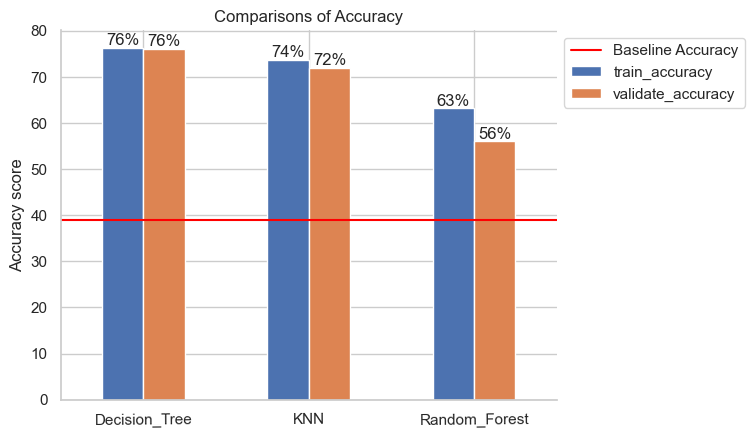

In [142]:
viz_models_accuracy(models_df)